In [88]:
import pandas as pd
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

In [89]:
data = pd.read_csv('AirQualityUCI.csv', sep=';')

In [90]:

columns_to_clean = ['C6H6(GT)', 'T', 'RH', 'AH']

for col in columns_to_clean:
    data[col] = data[col].str.replace(',', '.')  # replace comma with dot
    data[col] = pd.to_numeric(data[col], errors='coerce') #convert to numeric

#drop columns with missing values
data_cleaned = data.drop(columns=['Unnamed: 15', 'Unnamed: 16']).dropna()

In [91]:
#convert col Date and col Time to col DateTime index
data_cleaned['DateTime'] = pd.to_datetime(data_cleaned['Date'] + ' ' + data_cleaned['Time'], format='%d/%m/%Y %H.%M.%S')
data_cleaned = data_cleaned.set_index('DateTime')

#Then drop the original columns Date and Time
data_cleaned = data_cleaned.drop(columns=['Date', 'Time'])

#convert all columns to numeric
data_cleaned = data_cleaned.apply(pd.to_numeric, errors='coerce')

#drop rows with NAN values
data_cleaned = data_cleaned.dropna()

#split data (80% train, 20% test)
train_size = int(len(data_cleaned) * 0.8)
train_data = data_cleaned.iloc[:train_size]
test_data = data_cleaned.iloc[train_size:]

In [92]:
data

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
data_cleaned

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
DateTime,,,,,,,,,,,,,
2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-11 01:00:00,1.0,1136.0,31.0,3.3,672.0,62.0,1453.0,76.0,1333.0,730.0,10.7,60.0,0.7702
2004-03-11 04:00:00,-200.0,1011.0,14.0,1.3,527.0,21.0,1818.0,34.0,1197.0,445.0,10.1,60.5,0.7465
2004-03-11 08:00:00,2.0,1333.0,64.0,8.0,900.0,174.0,1136.0,112.0,1517.0,1102.0,10.8,57.4,0.7408
2004-03-11 23:00:00,1.0,913.0,26.0,2.6,629.0,47.0,1565.0,53.0,1252.0,552.0,8.2,60.8,0.6657
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-01-09 04:00:00,-200.0,934.0,-200.0,2.3,609.0,70.0,976.0,55.0,1094.0,581.0,13.7,61.1,0.9537
2005-01-12 04:00:00,-200.0,1002.0,-200.0,4.2,722.0,162.0,807.0,85.0,1161.0,998.0,10.7,71.3,0.9161
2005-01-15 04:00:00,-200.0,978.0,-200.0,4.8,756.0,266.0,834.0,115.0,1015.0,878.0,2.4,86.6,0.6369


In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(14), object(3)
memory usage: 1.2+ MB


In [95]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2137 entries, 2004-03-10 19:00:00 to 2005-01-21 04:00:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         2137 non-null   float64
 1   PT08.S1(CO)    2137 non-null   float64
 2   NMHC(GT)       2137 non-null   float64
 3   C6H6(GT)       2137 non-null   float64
 4   PT08.S2(NMHC)  2137 non-null   float64
 5   NOx(GT)        2137 non-null   float64
 6   PT08.S3(NOx)   2137 non-null   float64
 7   NO2(GT)        2137 non-null   float64
 8   PT08.S4(NO2)   2137 non-null   float64
 9   PT08.S5(O3)    2137 non-null   float64
 10  T              2137 non-null   float64
 11  RH             2137 non-null   float64
 12  AH             2137 non-null   float64
dtypes: float64(13)
memory usage: 233.7 KB


Root Mean Squared Error: 365.32477921518307


c:\Users\NguyenHuuNghia\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


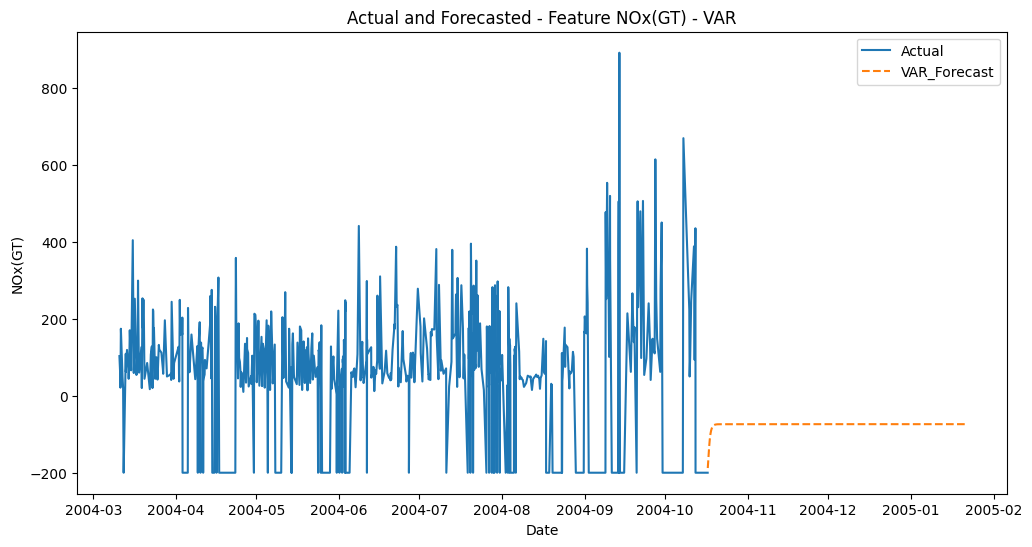

In [96]:
#fit VAR model
model_var = VAR(train_data)
fitted_model = model_var.fit()

#forcast
lag_order = fitted_model.k_ar
forecast_steps = len(test_data)
forecast = fitted_model.forecast(train_data.values[-lag_order:], forecast_steps)

#convert forecast to DataFrame for comparison with actual
forecast_df = pd.DataFrame(forecast, index=test_data.index, columns=train_data.columns)

#evaluate
rmse = np.sqrt(mean_squared_error(test_data['NOx(GT)'], forecast_df['NOx(GT)']))
print(f'Root Mean Squared Error: {rmse}')

#visualize
plt.figure(figsize=(12, 6))
plt.plot(train_data['NOx(GT)'], label='Actual')
plt.plot(forecast_df['NOx(GT)'], label='VAR_Forecast', linestyle='--')
plt.title('Actual and Forecasted - Feature NOx(GT) - VAR')
plt.xlabel('Date')
plt.ylabel('NOx(GT)')
plt.legend()

In [97]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error


In [98]:
#B1. Create lagged features
def create_lagged_features(data, n_lags):
    data_lagged = data.copy()
    for i in range(1, n_lags + 1):
        data_lagged[f'NOx(GT)_lag{i}'] = data_lagged['NOx(GT)'].shift(i)
    return data_lagged.dropna()

n_lags = 3
#apply lagged feature generation to both train and test data
train_data_lagged = create_lagged_features(train_data, n_lags)
test_data_lagged = create_lagged_features(test_data, n_lags)

In [99]:
#B2. Separate X and y
X_train = train_data_lagged.drop(columns='NOx(GT)')
y_train = train_data_lagged['NOx(GT)']

X_test = test_data_lagged.drop(columns='NOx(GT)')
y_test = test_data_lagged['NOx(GT)']

In [100]:
#B3. Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [101]:
#B4. Forecast
y_pred = xgb_model.predict(X_test)

Root Mean Squared Error: 115.37283419633845


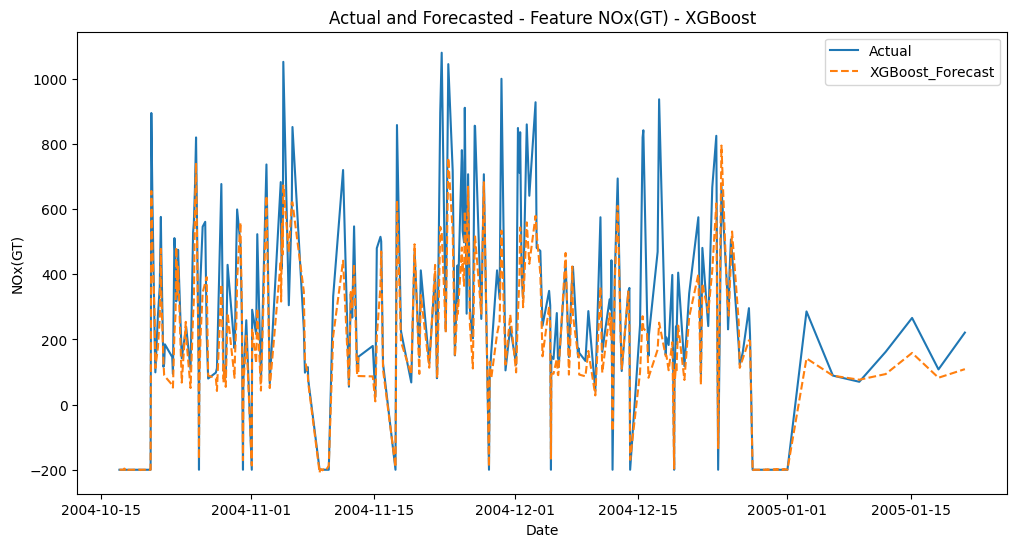

In [102]:
#B5. Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')

#B6. Visualize
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='XGBoost_Forecast', linestyle='--')
plt.title('Actual and Forecasted - Feature NOx(GT) - XGBoost')
plt.xlabel('Date')
plt.ylabel('NOx(GT)')
plt.legend()